# Python Learn by Doing: ENSO Analysis

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Date:** May 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, jupyter (and cartopy for one of the Your Turn assignments)

**Links:** **[github repo link](https://github.com/kerriegeil/MSU_py_training)**, [link to this notebook](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/enso_analysis.ipynb)

**Description:**

This notebook helps the learner build intermediate python programming skills through data query, manipulation, analysis, and visualization. Learning will be centered around the El Nino Southern Oscillation (ENSO) mode of climate variability and its effects on temperature and precipitation. The notebook is aimed at learners who already have intermediate programming skills and some knowledge of statistics. 

# Collection of Useful Links

- [documentation page for every version of Python](https://www.python.org/doc/versions/)
- every version of Python also includes a tutorial e.g. [The Python Tutorial v3.12.3](https://docs.python.org/release/3.12.3/tutorial/index.html)
- this is not technically a link, but Google is your friend! If there is something you want to learn how to do with python, just Google it and click through the search results to see if you can find an answer. A Google search will often return results from online forums like Stack Overflow where someone has asked the same question and received several answers. This same principle works for figuring out conda and jupyter things. Chances are the answer is a quick web search away
- [jupyter markdown cheat sheet](https://notebook.community/tschinz/iPython_Workspace/00_Admin/CheatSheet/Markdown%20CheatSheet)
- enso background link
- [xarray documentation](https://docs.xarray.dev/en/stable/) which includes the api reference, getting started guide, user guide, and developer info
- [kerrie's github repo](https://github.com/kerriegeil/MSU_py_training) is the current location where this notebooks lives and receives updates, this may eventually move to an MSU enterprise repo
- **[PythonWorkshop_Data.zip](https://www.northerngulfinstitute.org/projects/rgmg/PythonWorkshop_Data.zip)**, a temporary link to the data used in the python: learn by doing workshop, we're still working on a permanent solution for hosting the data and notebooks but data should be available at this link until 3 June 2024

# Introduction to ENSO

Put a description of what they are

Include a bunch of links
different ENSO indices https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni




# Science Questions

This notebook will investigate the following ENSO-related science questions (using simple statistics) as a way to pick up some useful intermediate python programming skills:

1) How many strong El Nino and La Nina events occurred from 1948-2023? How many periods of neutral conditions?
2) Using composite analysis, what pattern do we see in sea surface temperature during El Nino and La Nina conditions?
3) During boreal winter (DJF), where do El Nino and La Nina conditions affect temperature and precipitation globally?
4) Which areas of the United States experience statistically significant ENSO effects on winter (DJF) temperature and precipitation?
5) 

**Disclaimer:** This notebook is intended for python programming learning. There are many datasets and statistical methods we could use to answer our science questions. The techniques used in this notebook are chosen for their simplicity since we are focused on learning intermediate programming skills as opposed to a focus on producing peer-review level analyses. You will undoubtedly see different techniques, thresholds, seasons, and more complex statisical methods used in ENSO literature. 


# Importing Python Packages and Defining Your Workspace


In [1]:
# importing all the python packages we will need here

import os
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.signal import detrend

# import numpy.testing as npt
import warnings

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

Cannot find header.dxf (GDAL_DATA is not defined)


In [2]:
# learners need to update these paths to reflect locations on their own computer/workspace

# path to your working directory (where this notebook is on your computer)
work_dir = r'C://Users/kerrie/Documents/01_LocalCode/repos/MSU_py_training/learn_by_doing/ENSO/' 
# work_dir = r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/ENSO/' 

# path to where you'll download and store the data files
data_dir = r'C://Users/kerrie/Documents/02_LocalData/tutorials/ENSO/'
# data_dir=r'C://Users/kerrie.WIN/Documents/code/MSU_py_training/learn_by_doing/ENSO/'

# path to write output files and figures
output_dir = work_dir+'outputs/'

# create directories if they don't exist already
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Obtaining the Data

We will need the following data over many data years:


data description | frequency | units | dataset name | source
---|---|---|---|---
nino 3.4 sea surface temperature index | monthly | C | Nino 3.4 SST index | [NOAA PSL](https://psl.noaa.gov/gcos_wgsp/Timeseries/Nino34/)
sea surface temperature | monthly | C | JMA COBE2 | [via NOAA PSL](https://psl.noaa.gov/data/gridded/data.cobe2.html)
average air temperature | monthly | C | BEST | [Berkeley Earth](https://berkeleyearth.org/data/)
precipitation | monthly | mm/day | NOAA PREC/L | [NOAA PSL](https://psl.noaa.gov/data/gridded/data.precl.html)

<br>

<font color="green"><b>**If you haven't already, download **[PythonWorkshop_Data.zip](https://www.northerngulfinstitute.org/projects/rgmg/PythonWorkshop_Data.zip)** and unzip to the same directory where you have this notebook saved.**</b></font> (If you downloaded the whole repo as a zip file, unzip that, and then you'll want to unzip PythonWorkshop_Data.zip inside the learn_by_doing repo directory. After unzipping you should have the directory learn_by_doing/data/).


Scripted downloads of the datasets used here can be found in a separate notebook called [get_enso_datasets.ipynb](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/get_datasets/get_enso_datasets.ipynb). If you haven't obtained the data already, use the get_enso_datasets notebook to download the Nino3.4 index, HadISST1 sea surface temperature, Berkeley Earth temperature, and GPCC precipitation data. 

# Data Pre-processing

We'll execute the following steps on each dataset to prepare our data for analysis:

- make sure every dataset has identical dimension names and dimension order (time,lat,lon)
- make sure every dataset has identical time coordinate labels (datetimes at month start)
- subset every to our analysis years 1948-2023
- make sure longitudes range ascending from -180 to 180
- make sure latitudes range ascending
- detrend 
- calculate anomalies using base period 1981-2010 for sea surface temperature, precipitation, and air temperature


Why detrend?

Part of our analysis later in the notebook will involve correlating the nino3.4 index timeseries with both the temperature and precipitation timeseries. When correlating over long periods of time it's best to remove low-frequency features of the timeseries. In our case, we'll detrend by removing the long term linear trend from each timeseries aka "removing the climate change signal". 

There are plenty of other ways to detrend a timeseries that we won't cover here. How do you know which method to choose? Look at what's being done in similar scientific literature and, of course, test multiple methods to ensure your results are robust. 

Here we'll keep it simple by using a linear detrend since we've already covered that in a previous workshop day and because it's a frequently used method in the scientific literature. Also, I haven't shown it here but detrending using this method (vs. not detrending at all) does not impact the other analyses in this notebook.

In [3]:
# filenames
nino_f = data_dir+'nino34_anomalies_monthly_NOAA.txt'
sst_f = data_dir+'sst_monthly_COBE2_JMA.nc'
t_f = data_dir+'tavg_monthly_BerkeleyEarth.nc'
pr_f = data_dir+'precip_monthly_PRECL_NOAA.nc'

# subset years
year_start = '1948'
year_end = '2023'

# base period years (for anomalies)
base_start = '1981'
base_end = '2010'

## Nino 3.4 Index

our data file contains a row for each year of data and each column is one of 12 monthly anomaly values for the Nino 3.4 area 

the base period 1981-2010

In [34]:
# load nino3.4 index data

# there are plenty of ways to load txt data, we'll use pandas
nino_raw=pd.read_csv(nino_f,sep='\s+',skiprows=1,skipfooter=7,header=None,index_col=0,na_values=-99.99,engine='python')
nino_raw

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1870,-1.00,-1.20,-0.83,-0.81,-1.27,-1.08,-1.04,-0.88,-0.53,-0.92,-0.79,-0.79
1871,-0.25,-0.58,-0.43,-0.50,-0.70,-0.53,-0.60,-0.33,-0.24,-0.33,-0.31,-0.58
1872,-0.72,-0.62,-0.50,-0.77,-0.62,-0.52,-0.32,-0.85,-1.02,-0.94,-0.79,-0.88
1873,-0.78,-1.01,-1.31,-0.67,-0.53,-0.48,-0.58,-0.39,-0.34,-0.78,-0.77,-0.70
1874,-0.93,-1.06,-1.40,-0.94,-0.86,-0.72,-1.00,-1.05,-1.13,-1.25,-1.33,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...
2020,0.64,0.48,0.36,0.49,-0.12,-0.21,-0.04,-0.42,-0.66,-1.19,-1.01,-0.98
2021,-1.04,-0.94,-0.72,-0.55,-0.41,-0.06,-0.20,-0.38,-0.50,-0.78,-0.88,-1.07
2022,-0.77,-0.68,-0.84,-0.90,-1.02,-0.77,-0.56,-0.96,-1.06,-0.99,-0.76,-0.86


In [35]:
# collapse the data into a 1D array timeseries
nino=nino_raw.to_numpy().flatten()

# len(nino),nino

In [36]:
# create datetimes
dates=pd.date_range('1870-01-01','2024-12-01',freq='MS')

# len(dates),dates[0:3]

In [37]:
# create an xarray object with metadata labels attached (time)
nino=xr.DataArray(nino,name='nino',dims='time',coords={'time':dates})

# assign some variable attributes
nino.attrs['standard_name']='nino3.4 index'
nino.attrs['units']='C'
# nino

In [38]:
# subset in time using time labels
nino=nino.sel(time=slice(year_start,year_end))
# nino

In [39]:
# # use scipy.signal.detrend to remove linear trend
# dnino=detrend(nino)
# nino[:]=dnino  # numpy --> xarray

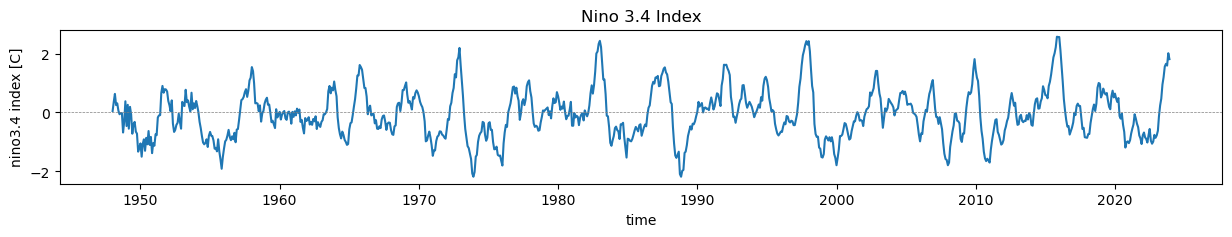

In [40]:
# plot it
fig=plt.figure(figsize=(15,2))
nino.plot()
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=0.5)
plt.title("Nino 3.4 Index")
plt.show()

## Sea Surface Temperature

In [41]:
# get data
ds=xr.open_dataset(sst_f)
# ds

In [42]:
# pull variable from xr dataset
sst=ds.sst
sst

<xarray.DataArray 'sst' (time: 2091, lat: 180, lon: 360)> Size: 542MB
[135496800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 17kB 1850-01-01 1850-02-01 ... 2024-03-01
Attributes:
    long_name:     Monthly Means of Global Sea Surface Temperature
    valid_range:   [-5. 40.]
    units:         degC
    var_desc:      Sea Surface Temperature
    dataset:       COBE-SST2 Sea Surface Temperature
    statistic:     Mean
    parent_stat:   Individual obs
    level_desc:    Surface
    actual_range:  [-3.0000002 34.392    ]

In [43]:
sst=sst.reindex(lat=sst.lat[::-1])
sst

<xarray.DataArray 'sst' (time: 2091, lat: 180, lon: 360)> Size: 542MB
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.727   , -1.73    , ..., -1.725   , -1.727   ],
        [-1.707   , -1.707   , ..., -1.707   , -1.707   ]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.715   , -1.715   , ..., -1.712   , -1.712   ],
        [-1.692   , -1.692   , ..., -1.695   , -1.695   ]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.691638, -1.691638, ..., -1.689138, -1.686638],
        [-1.669138, -1.669138, ..., -1.671638, -1.671638]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.691129, -1.69363 , ..., -1.68863 , -1.691129],
        [-1.68363 , -1.68363 , ..., -1.681129, -1.681129]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 17kB 1850-01-01 1850-02-01 ... 2024-03-01
Attributes:
    long_name:     Monthly Means of Global Sea Surface Temperature
    valid_range:   [-5. 40.]
    units:         degC
    var_desc:      Sea Surface Temperature
    dataset:       COBE-SST2 Sea Surface Temperature
    statistic:     Mean
    parent_stat:   Individual obs
    level_desc:    Surface
    actual_range:  [-3.0000002 34.392    ]

In [44]:
# subset in time
sst=sst.sel(time=slice(year_start,year_end))
# sst

In [45]:
# change longitudes from 0 to 360 to -180 to 180
# some plotting functions have problems when longitude is 0 to 360

sst.coords['lon']=xr.where(sst.coords['lon']>180,sst.coords['lon']-360,sst.coords['lon'])
# sst

In [46]:
# reorder longitudes so they are ascending
# we'll use roll, sort would also work
roll_len=len(sst.lon)//2
sst=sst.roll(lon=roll_len,roll_coords=True)
sst

<xarray.DataArray 'sst' (time: 912, lat: 180, lon: 360)> Size: 236MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.695    , -1.695    , -1.695    , ..., -1.692    ,
         -1.69     , -1.69     ],
        [-1.6800001, -1.6800001, -1.6800001, ..., -1.6800001,
         -1.6800001, -1.6800001],
        [-1.695    , -1.695    , -1.695    , ..., -1.695    ,
         -1.695    , -1.695    ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [-1.6024995, -1.6024995, -1.6074996, ..., -1.5999995,
         -1.6024995, -1.5999995],
        [-1.5974995, -1.6024995, -1.6024995, ..., -1.5949996,
         -1.5949996, -1.5999995],
        [-1.5999995, -1.5999995, -1.6024995, ..., -1.5949996,
         -1.5974995, -1.5999995]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.6791934, -1.6816934, -1.6816934, ..., -1.6766934,
         -1.6816934, -1.6816934],
        [-1.6616935, -1.6591934, -1.6591934, ..., -1.6591934,
         -1.6616935, -1.6616935],
        [-1.6816934, -1.6816934, -1.6816934, ..., -1.6791934,
         -1.6766934, -1.6791934]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2023-12-01
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:     Monthly Means of Global Sea Surface Temperature
    valid_range:   [-5. 40.]
    units:         degC
    var_desc:      Sea Surface Temperature
    dataset:       COBE-SST2 Sea Surface Temperature
    statistic:     Mean
    parent_stat:   Individual obs
    level_desc:    Surface
    actual_range:  [-3.0000002 34.392    ]

Scipy.signal.detrend() does not accept nans. So, detrending a 3D array with nans is a bit more complicated than detrending our 1D nino3.4 index which didn't have any nans.

First we'll remove nans and replace them with zero. Then detrend. Then put the nans back.

This is ok here because the only places we have nan are ocean grid cells where all times are nan. If we had random nans in the timeseries for land points, we wouldn't use this fill-with-zero method. We'd have to take an extra step to address nans either by filling them with other data values (like the mean value) or eliminating grid cells with intermittent nans from the analysis all together.

In [47]:
# # detrend

# # keep track of where nans are
# nanmask=xr.where(np.isfinite(sst),0,1)  # nan cells = 1

# # fill nan with 0 because scipy.signal.detrend doesn't accept nan
# sst=sst.fillna(0)

# # linear detrend
# dsst=detrend(sst,axis=0)

# # numpy back to xarray
# sst[:,:,:]=dsst

# # put nans back
# sst=xr.where(nanmask,np.nan,sst)

In [48]:
# calculate anomalies

# first calculate the monthly climatological values (long term means) over the base period
sst_base=sst.sel(time=slice(base_start,base_end))  # subset in time
sst_clim=sst_base.groupby(sst_base.time.dt.month).mean('time')  # long term means of each month
# sst_clim

In [49]:
# now calculate the anomalies
sst_anom=sst.groupby(sst.time.dt.month) - sst_clim

# assign some variable attributes
sst_anom.attrs['standard_name']='sst anomaly'
sst_anom.attrs['units']='C'
sst_anom

<xarray.DataArray 'sst' (time: 912, lat: 180, lon: 360)> Size: 236MB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [-2.38418579e-07, -4.00185585e-04, -2.00271606e-04, ...,
         -3.66568565e-04,  3.32951546e-04,  2.33054161e-04],
        [-1.00016594e-04,  1.19209290e-07,  1.19209290e-07, ...,
          1.19209290e-07,  1.19209290e-07, -1.00016594e-04],
        [-2.38418579e-07, -2.38418579e-07, -2.38418579e-07, ...,
         -2.38418579e-07, -2.38418579e-07, -2.38418579e-07]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
          8.69674683e-02,  8.58675241e-02,  8.43672752e-02],
        [ 9.02005434e-02,  8.79004002e-02,  8.67004395e-02, ...,
          9.07673836e-02,  9.08674002e-02,  8.86005163e-02],
        [ 7.72005320e-02,  7.76336193e-02,  7.80669451e-02, ...,
          7.98667669e-02,  7.88000822e-02,  7.73338079e-02]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [ 2.05070972e-02,  1.80070400e-02,  1.81069374e-02, ...,
          2.20401287e-02,  1.82069540e-02,  1.80070400e-02],
        [ 1.85067654e-02,  2.10068226e-02,  2.08067894e-02, ...,
          2.05068588e-02,  1.83067322e-02,  1.91065073e-02],
        [ 1.53063536e-02,  1.53063536e-02,  1.55061483e-02, ...,
          1.78064108e-02,  1.91730261e-02,  1.78064108e-02]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2023-12-01
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    month    (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  sst anomaly
    units:          C

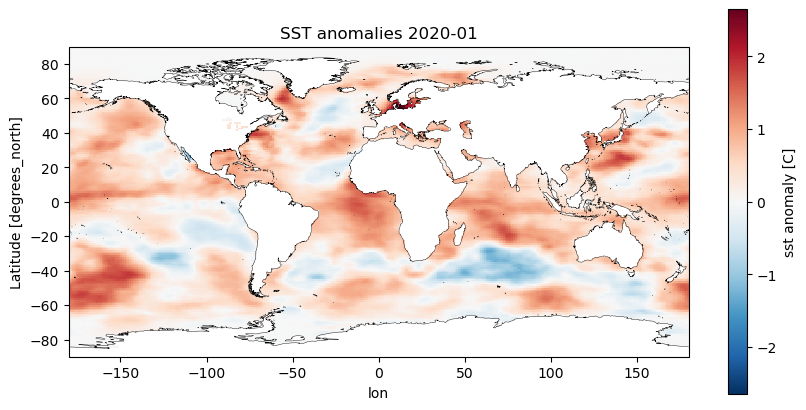

In [50]:
# plot it
ptime='2020-01'

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
sst_anom.sel(time=ptime).plot(ax=ax)
plt.title('SST anomalies '+ptime)
plt.show()

## Precipitation

In [51]:
ds=xr.open_dataset(pr_f)
ds

<xarray.Dataset> Size: 237MB
Dimensions:  (lat: 180, lon: 360, time: 915)
Coordinates:
  * lat      (lat) float32 720B 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 1kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2024-03-01
Data variables:
    precip   (time, lat, lon) float32 237MB ...
Attributes:
    title:          Precipitation Reconstruction over Land (PREC/L): 1.0x1.0
    platform:       Analyses
    institution:    NOAA ESRL/PSD
    citation:       Chen, M., P. Xie, J. E. Janowiak, and P. A. Arkin, 2002: ...
    history:        created 01/2011 by CAS\nConverted to chunked, deflated Ne...
    Conventions:    CF-1.2
    dataset_title:  Precipitation Reconstruction over Land (PREC/L)
    data_modified:  2019-02-25
    References:     http://www.psl.noaa.gov/data/gridded/data.precl.html

In [52]:
# pull variable from xr dataset
pr=ds.precip

# this data's times already match nino's so we don't need to re-assign the coordinate labels
# just subset
pr=pr.sel(time=slice(year_start,year_end))

# reverse latitudes
pr=pr.reindex(lat=pr.lat[::-1])

# change longitudes
pr.coords['lon']=xr.where(pr.coords['lon']>180,pr.coords['lon']-360,pr.coords['lon'])
roll_len=len(pr.lon)//2
pr=pr.roll(lon=roll_len,roll_coords=True)

# # detrend
# nanmask=xr.where(np.isfinite(pr),0,1)  # keep track of nans
# pr=pr.fillna(0)  # nan --> 0 
# dpr=detrend(pr,axis=0)  # linear detrend
# pr[:,:,:]=dpr  # numpy --> xarray
# pr=xr.where(nanmask,np.nan,pr)  # put nans back

# calculate anomalies
pr_base=pr.sel(time=slice(base_start,base_end))
pr_clim=pr_base.groupby(pr_base.time.dt.month).mean('time')
pr_anom=pr.groupby(pr.time.dt.month) - pr_clim

# assign some variables attributes
pr_anom.attrs['standard_name']='pr anomaly'
pr_anom.attrs['units']='mm/day'

# pr_anom

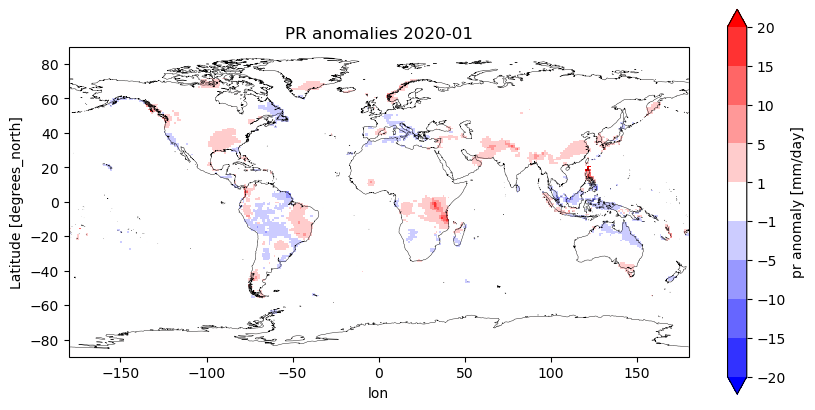

In [53]:
# plot it
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)

pr_anom.sel(time=ptime).plot(levels=[-20,-15,-10,-5,-1,1,5,10,15,20],extend='both',cmap='bwr')
plt.title('PR anomalies '+ptime)
plt.show()

## Temperature

In [54]:
ds=xr.open_dataset(t_f)
# ds

There are a lot of things that are different about this data file compared to the others
- it is provided as anomalies using base period 1951-1980
- it has an extra dimension due to the climatology variable included in the file
- the latitude and longitude dimension names (vs lat and lon)
- the longitudes are -180 to 180 already
- the latitudes are sorted ascending already
- the time coordinate is given as float values instead of datetimes

In [55]:
# replace whacky float times with datetimes to match the other datasets
dates=pd.date_range('1750-01-01','2024-03-01',freq='MS')
ds['time']=dates

# we also need to rename the dimension 'month_number' for groupby to work correctly (groupby likes the label 'month')
# and so we don't trip up later we'll rename latitude longitude to lat and lon like the other datasets
ds=ds.rename({'month_number':'month','latitude':'lat','longitude':'lon'})
# ds

this data is provided as anomalies using the base period 1951-1980, we'll change the base period to match the rest of our data

In [56]:
# change base period

# pull variables from xr dataset
t_anom_5180=ds.temperature
clim_5180=ds.climatology

# create temperature values working backward with anomalies plus climatology
t=t_anom_5180.groupby(t_anom_5180.time.dt.month)+clim_5180

# # detrend
# nanmask=xr.where(np.isfinite(t),0,1)  # keep track of nans
# t=t.fillna(0)  # nan --> 0 
# dt=detrend(t,axis=0)  # linear detrend
# t[:,:,:]=dt  # numpy --> xarray
# t=xr.where(nanmask,np.nan,t)  # put nans back

# new base period climatological values
t_base=t.sel(time=slice(base_start,base_end))  # subset in time
clim_8110 = t_base.groupby(t_base.time.dt.month).mean('time')  # long term means for each month

# anomalies with new base period
t_anom=t.groupby(t.time.dt.month)-clim_8110

# subset in time to match other datasets
t_anom=t_anom.sel(time=slice(year_start,year_end))

# assign some variable attributes
t_anom=t_anom.rename('tavg')
t_anom.attrs['standard_name']='T anomaly'
t_anom.attrs['units']='C'

# t_anom

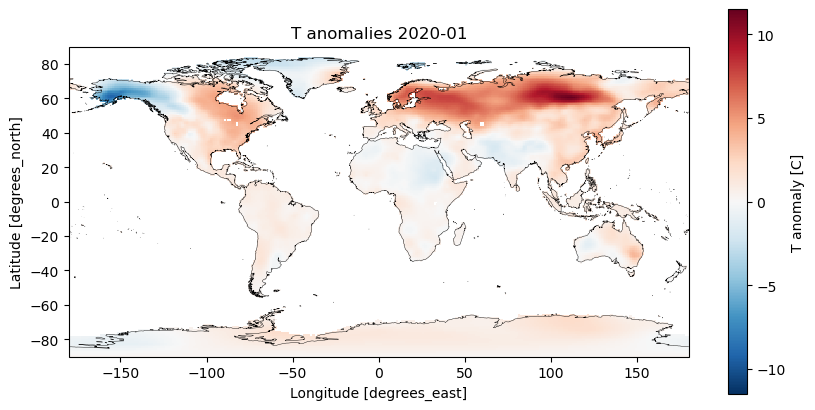

In [57]:
# plot it

fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)

t_anom.sel(time=ptime).plot()
plt.title('T anomalies '+ptime)
plt.show()

In [58]:
t_anom

<xarray.DataArray 'tavg' (time: 912, lat: 180, lon: 360)> Size: 236MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.82476044, -0.82307625, -0.82136726, ..., -0.8296833 ,
         -0.8280659 , -0.82642174],
        [-0.9759979 , -0.97014046, -0.96421814, ..., -0.99312973,
         -0.9874916 , -0.9817829 ],
        [-1.1317635 , -1.1211376 , -1.1103897 , ..., -1.1628838 ,
         -1.1526432 , -1.1422672 ],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 7kB 1948-01-01 1948-02-01 ... 2023-12-01
    month    (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
Attributes:
    standard_name:  T anomaly
    units:          C

We're now ready to start our analysis with the variables `nino`, `sst_anom`, `pr_anom`, and `t_anom`

Let's double check our 4 variable shapes below: 

In [59]:
# look at data shapes
nino.shape, sst_anom.shape, pr_anom.shape, t_anom.shape

((912,), (912, 180, 360), (912, 180, 360), (912, 180, 360))

In [60]:
# check time start/end is the same for all data
# another way to do this would be with assert statements or with numpy.testing

variables=[nino, sst_anom, pr_anom, t_anom]

for var in variables:
    print(var.name, var.coords['time'].data[0],var.coords['time'].data[-1])

nino 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
sst 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
precip 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000
tavg 1948-01-01T00:00:00.000000000 2023-12-01T00:00:00.000000000


In [61]:
# clean up 
del ds,nino_raw,pr,pr_base,pr_clim,sst,sst_base,sst_clim,t,t_anom_5180,t_base

In [62]:
del dnino,dsst,dpr,dt

# Begin Main Analysis

## 1) How many strong El Nino and La Nina events have occurred from 1948 to 2023? How many neutral periods?

The answer to this question, of course, depends on how we define strong ENSO events and neutral conditions.

There are multiple methods for identifying ENSO events, but we will use the following criteria:
- Input data: Nino 3.4 Index 5-month centered running mean
- Criteria: 5 consecutive months exceeding the threshold value
- Threshold: +/- 0.7 C

In [90]:
# constants based on our criteria
nmonths=5
event_thresh=0.7
neutral_thresh=0.35

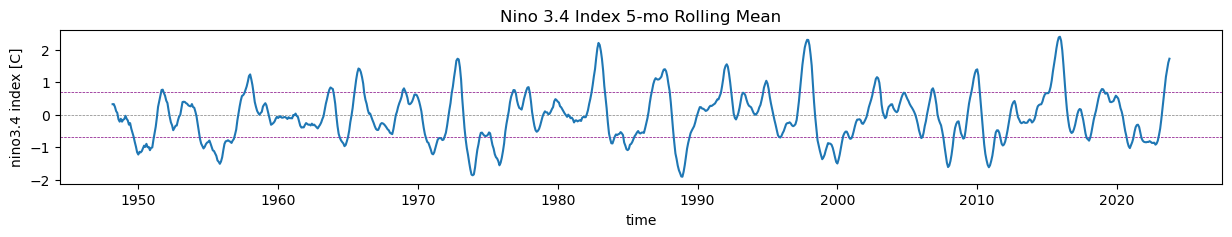

In [91]:
# first calculate the rolling mean
nino_rollmean=nino.rolling(time=nmonths,center=True).mean()

# plot it
fig=plt.figure(figsize=(15,2))
plt.axhline(y=-event_thresh,color='purple',linestyle='dashed',linewidth=0.5)
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=0.5)
plt.axhline(y=event_thresh,color='purple',linestyle='dashed',linewidth=0.5)

nino_rollmean.plot()
plt.title("Nino 3.4 Index 5-mo Rolling Mean")
plt.show()

Anywhere the nino3.4 rolling mean (blue line) exceeds the thresholds (purple lines) is potentially an ENSO event. To identify which peaks and valleys in the timeseries qualify as ENSO events we need to identify where the thresholds are exceeded for at least 5 consecutive months.  

We'll use a for loop to identify ENSO events in the timeseries and mark months 
- during an El Nino event with +1
- during a La Nina event with -1 

We'll also use the criteria of 5 consecutive months under a threshold of +/-0.2C to indentify neutral conditions and mark months 
- during neutral periods with 0

In [92]:
# create an array to hold our results and initialize to nan
# this array is where we will fill values with +1,-1, or 0
nino_events=nino_rollmean.copy() 
nino_events[:]=np.nan

# look at the first 4 values
nino_events[0:4]

<xarray.DataArray 'nino' (time: 4)> Size: 32B
array([nan, nan, nan, nan])
Coordinates:
  * time     (time) datetime64[ns] 32B 1948-01-01 1948-02-01 ... 1948-04-01
Attributes:
    standard_name:  nino3.4 index
    units:          C

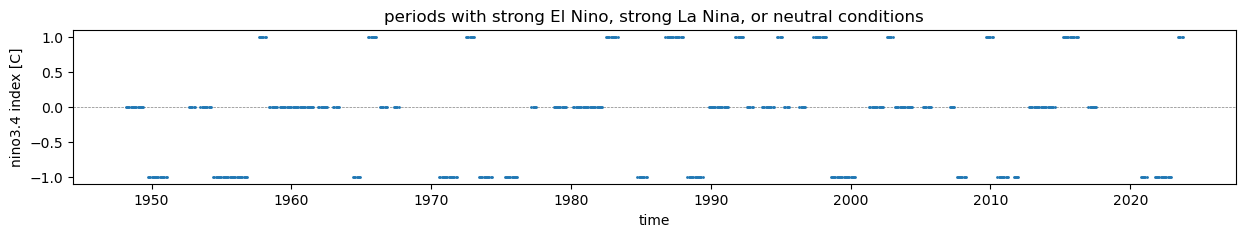

In [93]:
# loop through months and fill +1, -1, or 0 for windows of 5 months that meet our criteria

for i,value in enumerate(nino_rollmean):
    # La Nina conditions
    if  value < -event_thresh:
        # possible La Nina conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window < -event_thresh):
            nino_events[i:i+nmonths] = -1

    # El Nino conditions
    if  value > event_thresh:
        # possible El Nino conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(window > event_thresh):
            nino_events[i:i+nmonths]=1     
    
    # neutral conditions    
    if (-neutral_thresh < value < neutral_thresh):
        # possible neutral conditions, look forward 4 more months
        window=nino_rollmean[i:i+nmonths]
        if all(-neutral_thresh < window) & all(window < neutral_thresh):
            nino_events[i:i+nmonths]=0  

            
# plot it
fig=plt.figure(figsize=(15,2))
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=0.5)
nino_events.plot(linestyle='None',marker='o',markersize=1)
plt.title("periods with strong El Nino, strong La Nina, or neutral conditions")
plt.show()            

Above we have identified all the periods that meet our criteria, but this plot isn't too nice to look at.

Let's use the `nino_events` array to add shading to the nino_rollmean plot as well as count how many el nino and la nina events there are in the timeseries. To do this we'll get the start and end index of each ENSO and neutral event.

In [94]:
# # def get_event_bounds(id,event_bounds):
    
# for i,val in enumerate(nino_events[:-1]):    
    
#     # find each event start
#     if (val==id) and (start_flag==False):
#         istart=i
#         start_flag=True
#     # find each event end and save start/end times to a list
#     if (start_flag) and (iend==0) and (nino_events[i+1]!=id):
#         iend=i
#         # append a tuple (event start time, event end time) to our list of results
#         event_bounds.append((nino_events.time[istart].data,nino_events.time[iend].data))
#         # reset values so we can look for the next event
#         start_flag=False
#         iend=0

In [95]:
# first, we'll get the timing of the start and end of each event

# el nino
nino_bounds=[] # empty list to hold the results
istart=0
iend=0
start_flag=False

for i,val in enumerate(nino_events[:-1].data):    
    # find each nino start
    if (val==1) and (start_flag==False):
        istart=i
        start_flag=True
    # find each nino end and save start/end times to a list
    if (start_flag) and (iend==0) and (nino_events[i+1]!=1):
        iend=i
        # append a tuple (event start time, event end time) to our list of results
        nino_bounds.append((nino_events.time[istart].data,nino_events.time[iend].data))
        # reset values so we can look for the next event
        start_flag=False
        iend=0

len(nino_bounds),nino_bounds

(12,
 [(array('1957-09-01T00:00:00.000000000', dtype='datetime64[ns]'),
   array('1958-03-01T00:00:00.000000000', dtype='datetime64[ns]')),
  (array('1965-07-01T00:00:00.000000000', dtype='datetime64[ns]'),
   array('1966-02-01T00:00:00.000000000', dtype='datetime64[ns]')),
  (array('1972-07-01T00:00:00.000000000', dtype='datetime64[ns]'),
   array('1973-02-01T00:00:00.000000000', dtype='datetime64[ns]')),
  (array('1982-07-01T00:00:00.000000000', dtype='datetime64[ns]'),
   array('1983-05-01T00:00:00.000000000', dtype='datetime64[ns]')),
  (array('1986-10-01T00:00:00.000000000', dtype='datetime64[ns]'),
   array('1988-01-01T00:00:00.000000000', dtype='datetime64[ns]')),
  (array('1991-10-01T00:00:00.000000000', dtype='datetime64[ns]'),
   array('1992-05-01T00:00:00.000000000', dtype='datetime64[ns]')),
  (array('1994-10-01T00:00:00.000000000', dtype='datetime64[ns]'),
   array('1995-02-01T00:00:00.000000000', dtype='datetime64[ns]')),
  (array('1997-05-01T00:00:00.000000000', dtype='d

In [96]:
# la nina
nina_bounds=[] # empty list to hold the results
istart=0
iend=0
start_flag=False

for i,val in enumerate(nino_events[:-1]):    
    # find each nina start
    if (val==-1) and (start_flag==False):
        istart=i
        start_flag=True
    # find each nina end and save start/end times to a list
    if (start_flag) and (iend==0) and (nino_events[i+1]!=-1):
        iend=i
        # append a tuple (event start time, event end time) to our list of results
        nina_bounds.append((nino_events.time[istart].data,nino_events.time[iend].data))
        # reset values so we can look for the next event        
        start_flag=False
        iend=0 

# neutral
neutral_bounds=[] # empty list to hold the results
istart=0
iend=0
start_flag=False

for i,val in enumerate(nino_events[:-1]):    
    # find each neutral start
    if (val==0) and (start_flag==False):
        istart=i
        start_flag=True
    # find each neutral end and save start/end times to a list
    if (start_flag) and (iend==0) and (nino_events[i+1]!=0):
        iend=i
        # append a tuple (start time, end time) to our list of results
        neutral_bounds.append((nino_events.time[istart].data,nino_events.time[iend].data))
        # reset values so we can look for the next neutral period        
        start_flag=False
        iend=0

Now we have 3 lists (nino_bounds, nina_bounds, neutral_bounds) containing tuples of the start and end datetime for each event. 

The length of each list will tell us how many el nino, la nina, and neutral events we found in the time series 

In [97]:
print('How many strong el nino and la nina events occurred from 1948 to 2023?')
print(len(nino_bounds),'strong el nino events')
print(len(nina_bounds),'strong la nina events') 

print(f'(and {len(neutral_bounds)} periods of neutral conditions)')

How many strong el nino and la nina events occurred from 1948 to 2023?
12 strong el nino events
14 strong la nina events
(and 23 periods of neutral conditions)


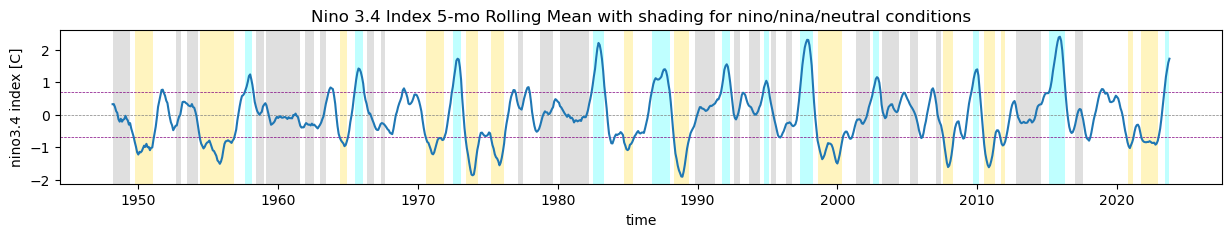

In [98]:
# plot the Nino 3.4 rolling mean with shading during el nino, la nina, and neutral conditions

fig=plt.figure(figsize=(15,2))

# horizontal guide lines
plt.axhline(y=-event_thresh,color='purple',linestyle='dashed',linewidth=0.5)
plt.axhline(y=0,color='grey',linestyle='dashed',linewidth=0.5)
plt.axhline(y=event_thresh,color='purple',linestyle='dashed',linewidth=0.5)

# plot the rolling mean timeseries with title
nino_rollmean.plot()
plt.title("Nino 3.4 Index 5-mo Rolling Mean with shading for nino/nina/neutral conditions")

# add blue shading during nino events
for tstart,tend in nino_bounds:
    plt.axvspan(tstart,tend, color='cyan', alpha=0.25, lw=0)

# add yellow shading during nina events    
for tstart,tend in nina_bounds:
    plt.axvspan(tstart,tend, color='gold', alpha=0.25, lw=0)

# add grey shading during neutral periods    
for tstart,tend in neutral_bounds:
    plt.axvspan(tstart,tend, color='grey', alpha=0.25, lw=0)

plt.show()

## 2) Using composite analysis, what pattern do we see in sea surface temperature during El Nino and La Nina conditions?

remember, our array of sea surface temperature anomalies is called **sst_anom**

and we've identified periods with el nino, la nina, or neutral conditions in the array called **nino_events**

A composite is just the time-mean of a group of sst anomaly maps for different months. In this case we'll have one group of sst anomalies for months with el nino conditions and another group of sst anomalies for months with la nina conditions. 

We'll also check what a composite of sst anomalies during neutral conditions looks like. We shouldn't see the strong spatial patterns during neutral conditions that we see during el nino or la nina conditions.

In [ ]:
# first make the el nino composite

# keep sst anomalies only for months during el nino events
# then take the average in time
sst_nino=sst_anom.where(nino_events==1).mean('time',keep_attrs=True)


# plot it

# this is how you get correct longitude labels 
# for PlateCarree projection with central_longitude in the Pacific
from cartopy.mpl.gridliner import LongitudeFormatter

fig=plt.figure(figsize=(12,4))

ax=fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_global()
# ax.set_xticks([0, 60, 120, 180, 240, 300, 360],crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(direction_label=False)#zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
sst_nino.plot(vmin=-2.,vmax=2.,cmap='RdBu_r',transform=ccrs.PlateCarree())
plt.title('mean sst anomalies during strong el nino events')
plt.show()

In [ ]:
# now make the la nina composite

# keep sst anomalies only for months during la nina events
# then take the average in time
sst_nina=sst_anom.where(nino_events==-1).mean('time',keep_attrs=True)

# plot it
sst_nina.plot(vmin=-2.,vmax=2.,cmap='RdBu_r')
plt.title('mean sst anomalies during strong la nina events')
plt.show()

In [ ]:
# and now a composite for neutral conditions

# keep sst anomalies only for months during neutral conditions
# then take the average in time
sst_neutral=sst_anom.where(nino_events==0).mean('time',keep_attrs=True)

# plot it
sst_neutral.plot(vmin=-2.,vmax=2.,cmap='RdBu_r')
plt.title('mean sst anomalies during neutral periods')
plt.show()

## 3) During boreal winter (DJF), where do El Nino and La Nina conditions affect temperature and precipitation globally?


In [ ]:
# get temperature anomalies only for times during el nino condition
t_nino=t_anom.where(nino_events==1,drop=True)

# now get only the winter months during el nino conditions and average months together
t_nino_DJF=t_nino.groupby(t_nino.time.dt.season)['DJF'].mean('time',keep_attrs=True)

# do the exact same thing for precipitation
pr_nino=pr_anom.where(nino_events==1,drop=True)
pr_nino_DJF=pr_nino.groupby(pr_nino.time.dt.season)['DJF'].mean('time',keep_attrs=True)

In [ ]:
fig=plt.figure(figsize=(12,4))

ax=fig.add_subplot(121,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
# ax.xaxis.set_visible(True)
# ax.yaxis.set_visible(True)
# ax.xaxis.label.set_visible(False)
# ax.yaxis.label.set_visible(False)
t_nino_DJF.plot(cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title('winter mean temperature anomalies\n during El Nino conditions')

ax=fig.add_subplot(122,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nino_DJF.plot(cmap='RdBu',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title('winter mean precipitation anomalies\n during El Nino conditions')

plt.tight_layout()
plt.show()

In [ ]:
# # plot it

# fig,axes=plt.subplots(ncols=2,figsize=(12, 4))

# t_nino_DJF.plot(ax=axes[0],cmap='RdBu_r')
# axes[0].set_title('winter mean temperature anomalies\n during El Nino conditions')

# pr_nino_DJF.plot(ax=axes[1],cmap='RdBu')
# axes[1].set_title('winter mean precipitation anomalies\n during El Nino conditions')

# plt.tight_layout()
# plt.show()

### Where are the above affects statistically significant?

use a t test for difference in means between two groups of data: anomalies during el nino winter months and anomalies during neutral winter months

(we could also test nino winter months vs all winter months and get very similar results)


In [ ]:
# first we'll create separate data samples to apply the statistical testing to

# same first step as above except this time we're not taking the mean in time
t_ninoDJF_group=t_nino.groupby(t_nino.time.dt.season)['DJF']  # t anomalies during el nino winters
pr_ninoDJF_group=pr_nino.groupby(pr_nino.time.dt.season)['DJF']  # pr anomalies during el nino winters

# # now do the same for the neutral DJFs
# t_nuet=t_anom.where(nino_events==0,drop=True) # t anomalies during all months with neutral conditions
# t_neutDJF_group=t_nuet.groupby(t_nuet.time.dt.season)['DJF']  # t anomalies during neutral winters

# pr_nuet=pr_anom.where(nino_events==0,drop=True)  # pr anomalies during all months with neutral conditions
# pr_neutDJF_group=pr_nuet.groupby(t_nuet.time.dt.season)['DJF']  # pr anomalies during neutral winters

# print('t data sample sizes:',t_ninoDJF_group.shape, t_neutDJF_group.shape) 
# print('pr data sample sizes:',pr_ninoDJF_group.shape, pr_neutDJF_group.shape) 

# now do the same for the neutral DJFs
t_nina=t_anom.where(nino_events==-1,drop=True) # t anomalies during all months with neutral conditions
t_ninaDJF_group=t_nina.groupby(t_nina.time.dt.season)['DJF']  # t anomalies during neutral winters

pr_nina=pr_anom.where(nino_events==-1,drop=True)  # pr anomalies during all months with neutral conditions
pr_ninaDJF_group=pr_nina.groupby(t_nina.time.dt.season)['DJF']  # pr anomalies during neutral winters

print('t data sample sizes:',t_ninoDJF_group.shape, t_ninaDJF_group.shape) 
print('pr data sample sizes:',pr_ninoDJF_group.shape, pr_ninaDJF_group.shape) 

In [ ]:
# t test for difference in means between two sample groups
# apply the statistical test using the scipy.stats package
# t_ttest=ss.ttest_ind(t_ninoDJF_group,t_neutDJF_group,axis=0)
t_ttest=ss.ttest_ind(t_ninoDJF_group,t_ninaDJF_group,axis=0)

# ss.ttest_ind returns an object with multiple numpy arrays attached as attributes
# you access them with .statistic, .pvalue, and .df
t_ttest.pvalue

In [ ]:
# for ease of plotting, we'll turn those numpy array results back into xarray data arrays
# which basically means we're adding the lat and lon dims/coordinate metadata back

t_tstat=xr.DataArray(t_ttest.statistic, coords={'lat':('lat',t_nino.coords['lat'].data),'lon':('lon',t_nino.coords['lon'].data)})
t_pval=xr.DataArray(t_ttest.pvalue, coords={'lat':('lat',t_nino.coords['lat'].data),'lon':('lon',t_nino.coords['lon'].data)})  
t_df=xr.DataArray(t_ttest.df, coords={'lat':('lat',t_nino.coords['lat'].data),'lon':('lon',t_nino.coords['lon'].data)})  
t_pval

In [ ]:
# t test for difference in means between two sample groups
# apply the statistical test using the scipy.stats package
# pr_ttest=ss.ttest_ind(pr_ninoDJF_group,pr_neutDJF_group)
pr_ttest=ss.ttest_ind(pr_ninoDJF_group,pr_ninaDJF_group)

# for ease of plotting, we'll turn those numpy array results back into xarray data arrays
# which basically means we're adding the lat and lon metadata back

pr_tstat=xr.DataArray(pr_ttest.statistic, coords={'lat':('lat',pr_nino.coords['lat'].data),'lon':('lon',pr_nino.coords['lon'].data)})
pr_pval=xr.DataArray(pr_ttest.pvalue, coords={'lat':('lat',pr_nino.coords['lat'].data),'lon':('lon',pr_nino.coords['lon'].data)}) 
pr_df=xr.DataArray(pr_ttest.df, coords={'lat':('lat',pr_nino.coords['lat'].data),'lon':('lon',pr_nino.coords['lon'].data)}) 

In [ ]:
# pr_ttest

In [ ]:
# make the same plot as above but only show the results where pval < 0.1
pval=0.1

fig=plt.figure(figsize=(12,4))

ax=fig.add_subplot(121,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_DJF.where(t_pval<pval).plot(cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title('winter mean temperature anomalies\n during El Nino conditions')

ax=fig.add_subplot(122,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nino_DJF.where(pr_pval<pval).plot(cmap='RdBu',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title('winter mean precipitation anomalies\n during El Nino conditions')

plt.tight_layout()
plt.show()

In [ ]:
fig=plt.figure(figsize=(12,4))

ax=fig.add_subplot(121,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_DJF.where(abs(t_tstat)>1.66).plot(cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title('t degrees of freedom')

In [ ]:
np.unique(t_df), np.unique(pr_df)

In [ ]:
pr_ninoDJF_group.shape,pr_ninaDJF_group.shape

In [ ]:
# pval=0.1

# fig,axes=plt.subplots(ncols=2,figsize=(12, 4))

# t_nino_DJF.where(t_pval<pval).plot(ax=axes[0],cmap='RdBu_r')
# axes[0].set_title('winter mean temperature anomalies\n during El Nino conditions')

# pr_nino_DJF.where(pr_pval<pval).plot(ax=axes[1],cmap='RdBu')
# axes[1].set_title('winter mean precipitation anomalies\n during El Nino conditions')

# plt.tight_layout()
# plt.show()

In [ ]:
t_ci_low=xr.DataArray(t_ttest.confidence_interval(confidence_level=0.90).low, coords={'lat':('lat',t_nino.coords['lat'].data),'lon':('lon',t_nino.coords['lon'].data)})
t_ci_hi=xr.DataArray(t_ttest.confidence_interval(confidence_level=0.90).high, coords={'lat':('lat',t_nino.coords['lat'].data),'lon':('lon',t_nino.coords['lon'].data)})
pr_ci_low=xr.DataArray(pr_ttest.confidence_interval(confidence_level=0.90).low, coords={'lat':('lat',pr_nino.coords['lat'].data),'lon':('lon',pr_nino.coords['lon'].data)})
pr_ci_hi=xr.DataArray(pr_ttest.confidence_interval(confidence_level=0.90).high, coords={'lat':('lat',pr_nino.coords['lat'].data),'lon':('lon',pr_nino.coords['lon'].data)})


In [ ]:
# near nogales
print(t_pval.sel(lat=30,lon=-111,method='nearest').data)
print(t_tstat.sel(lat=30,lon=-111,method='nearest').data)
print(t_ci_low.sel(lat=30,lon=-111,method='nearest').data)
print(t_ci_hi.sel(lat=30,lon=-111,method='nearest').data)


In [ ]:
# somewhere in canada
print(t_pval.sel(lat=55,lon=-111,method='nearest').data)
print(t_tstat.sel(lat=55,lon=-111,method='nearest').data)
print(t_ci_low.sel(lat=55,lon=-111,method='nearest').data)
print(t_ci_hi.sel(lat=55,lon=-111,method='nearest').data)


In [ ]:
#why is masking by confidence intervals different than pvals
fig=plt.figure(figsize=(12,4))

ax=fig.add_subplot(121,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
t_nino_DJF.where((t_ci_low > t_tstat)|(t_tstat > t_ci_hi)).plot(cmap='RdBu_r',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})
plt.title('winter mean temperature anomalies\n during El Nino conditions')

ax=fig.add_subplot(122,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
pr_nino_DJF.where((pr_ci_low > pr_tstat)|(pr_tstat > pr_ci_hi)).plot(cmap='RdBu',cbar_kwargs={'shrink':0.9,'orientation':'horizontal','pad':0.05})


plt.title('winter mean precipitation anomalies\n during El Nino conditions')

plt.tight_layout()
plt.show()

In [ ]:
# # t is the same as above but why is the pr totally different???
# fig,axes=plt.subplots(ncols=2,figsize=(12, 4))
# t_nino_DJF.where((t_ci_low > t_tstat)|(t_tstat > t_ci_hi)).plot(ax=axes[0],cmap='RdBu_r')
# axes[0].set_title('winter mean temperature anomalies\n during El Nino conditions')

# pr_nino_DJF.where((pr_ci_low > pr_tstat)|(pr_tstat > pr_ci_hi)).plot(ax=axes[1],cmap='RdBu_r')
# axes[1].set_title('winter mean precipitation anomalies\n during El Nino conditions')

# plt.tight_layout()
# plt.show()

# 4) Which areas of the United States experience statistically significant ENSO impacts on temperature and precipitation?

In [ ]:
# pr_nino=pr_anom.where(nino_events==1).mean('time')
# pr_nino.plot(cmap='RdBu')




In [ ]:
# pr_nina=pr_anom.where(nino_events==-1).mean('time')
# pr_nina.plot(cmap='RdBu')

In [ ]:
# pr_neutral=pr_anom.where(nino_events==0).mean('time')
# pr_neutral.plot(vmin=-3.5,vmax=3.5,cmap='RdBu')

In [ ]:
# pr_nino

In [ ]:
# pr_nino_conus=pr_nino.sel(lat=slice(51,23),lon=slice(230,300))

# fig=plt.figure(figsize=(10,8))
# ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
# ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
# ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
# ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
# cbar_kwargs={'shrink':0.5}
# pr_nino_conus.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs=cbar_kwargs)



In [ ]:
pr_anom_conus=pr_anom.sel(lat=slice(51,23),lon=slice(-125,-65))

pr_nino_conus=pr_anom_conus.where(nino_events==1,drop=True)
pr_ninoDJF_conus=pr_nino_conus.groupby(pr_nino_conus.time.dt.season)['DJF']

pr_ninoDJF_conus.shape

In [ ]:
t_anom_conus=t_anom.sel(lat=slice(23,51),lon=slice(-135,-60))

t_nino_conus=t_anom_conus.where(nino_events==1,drop=True)
t_ninoDJF_conus=t_nino_conus.groupby(t_nino_conus.time.dt.season)['DJF']

t_ninoDJF_conus.shape

In [ ]:
# neutral conditions
t_neut_conus=t_anom_conus.where(nino_events==0,drop=True)
t_neutDJF_conus=t_neut_conus.groupby(t_neut_conus.time.dt.season)['DJF']

pr_neut_conus=pr_anom_conus.where(nino_events==0,drop=True)
pr_neutDJF_conus=pr_neut_conus.groupby(pr_neut_conus.time.dt.season)['DJF']

In [ ]:
fig=plt.figure(figsize=(15,5))
titles=['mean DJF t anomalies during el nino','mean DJF pr anomalies during el nino']
cmaps=['RdBu_r','RdBu']
for i,data in enumerate([t_ninoDJF_conus,pr_ninoDJF_conus]):

    ax=fig.add_subplot(1,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
    ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
    ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
    cbar_kwargs={'shrink':0.6}
    data.mean('time',keep_attrs=True).plot(cmap=cmaps[i],cbar_kwargs=cbar_kwargs)#vmin=-7.5,vmax=7.5,cmap='RdBu')
    plt.title(titles[i])
plt.tight_layout()
plt.show()

In [ ]:
fig=plt.figure(figsize=(15,5))
titles=['mean DJF t anomalies during el nino','mean DJF p anomalies during el nino']
nino_data=[t_ninoDJF_conus,pr_ninoDJF_conus]
neutral_data=[t_neutDJF_conus,pr_neutDJF_conus]

for i,data_tuple in enumerate(zip(nino_data,neutral_data)):
    ttest=ss.ttest_ind(data_tuple[0],data_tuple[1])
    # pr_tstat=xr.DataArray(pr_ttest.statistic, coords={'lat':('lat',pr_nino.coords['lat'].data),'lon':('lon',pr_nino.coords['lon'].data)})
    pval=xr.DataArray(ttest.pvalue, coords={'lat':('lat',data_tuple[0].coords['lat'].data),'lon':('lon',data_tuple[0].coords['lon'].data)})     

    ax=fig.add_subplot(1,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
    ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
    ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
    cbar_kwargs={'shrink':0.6}
    data_tuple[0].mean('time',keep_attrs=True).where(pval<0.05).plot(cmap=cmaps[i],cbar_kwargs=cbar_kwargs)#vmin=-7.5,vmax=7.5,cmap='RdBu')
    plt.title(titles[i])
plt.tight_layout()
plt.show()

In [ ]:
fig=plt.figure(figsize=(15,5))
titles=['mean DJF t anomalies during el nino','mean DJF p anomalies during el nino']
nino_data=[t_ninoDJF_conus,pr_ninoDJF_conus]
neutral_data=[t_neutDJF_conus,pr_neutDJF_conus]

for i,data_tuple in enumerate(zip(nino_data,neutral_data)):
    ttest=ss.ttest_ind(data_tuple[0],data_tuple[1])
    tstat=xr.DataArray(ttest.statistic, coords={'lat':('lat',data_tuple[0].coords['lat'].data),'lon':('lon',data_tuple[0].coords['lon'].data)})
    ci_low=xr.DataArray(ttest.confidence_interval(confidence_level=0.80).low, coords={'lat':('lat',data_tuple[0].coords['lat'].data),'lon':('lon',data_tuple[0].coords['lon'].data)})
    ci_hi=xr.DataArray(ttest.confidence_interval(confidence_level=0.80).high, coords={'lat':('lat',data_tuple[0].coords['lat'].data),'lon':('lon',data_tuple[0].coords['lon'].data)})   

    ax=fig.add_subplot(1,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
    ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
    ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
    cbar_kwargs={'shrink':0.6}
    data_tuple[0].mean('time',keep_attrs=True).where((tstat<ci_low)|(tstat>ci_hi)).plot(cmap=cmaps[i],cbar_kwargs=cbar_kwargs)#vmin=-7.5,vmax=7.5,cmap='RdBu')
    plt.title(titles[i])
plt.tight_layout()
plt.show()

In [ ]:
# # fig=plt.figure(figsize=(15,6))
# # ax=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
# fig,axes=plt.subplots(ncols=2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
# # axes[0].add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
# # axes[0].add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
# # axes[0].add_feature(cf.STATES.with_scale("50m"),lw=0.3)
# # cbar_kwargs={'shrink':0.8}
# t_ninoDJF_conus.mean('time',keep_attrs=True).plot(ax=axes[0],cmap='RdBu')#,cbar_kwargs=cbar_kwargs)
# plt.tight_layout()
# # plt.show()
# plt.draw()

In [ ]:
fig=plt.figure(figsize=(15,6))

for i,(season,data) in enumerate(pr_nino_conus.groupby(pr_nino_conus.time.dt.season)):
    season_composite=data.mean('time')

    # fig.add_subplot(2,2,i+1)
    ax=fig.add_subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
    ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
    ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
    cbar_kwargs={'shrink':0.8}
    season_composite.plot(vmin=-1.6,vmax=1.6,cmap='RdBu',cbar_kwargs=cbar_kwargs)#vmin=-7.5,vmax=7.5,cmap='RdBu')
    plt.title(season)

plt.tight_layout()
plt.show()


In [ ]:
pr_nina_subset=pr_anom_conus.where(nino_events==-1,drop=True)
for season,data in pr_nina_subset.groupby(pr_nina_subset.time.dt.season):
    print(season,data.shape)

In [ ]:
fig=plt.figure(figsize=(15,6))

for i,(season,data) in enumerate(pr_nina_subset.groupby(pr_nina_subset.time.dt.season)):
    season_composite=data.mean('time')

    ax=fig.add_subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
    ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
    ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
    cbar_kwargs={'shrink':0.8}
    season_composite.plot(vmin=-1.6,vmax=1.6,cmap='RdBu',cbar_kwargs=cbar_kwargs)#vmin=-7.5,vmax=7.5,cmap='RdBu')
    plt.title(season)

plt.tight_layout()
plt.show()

In [ ]:
pr_neutral_subset=pr_anom_conus.where(nino_events==0,drop=True)
for season,data in pr_neutral_subset.groupby(pr_neutral_subset.time.dt.season):
    print(season,data.shape)

In [ ]:
fig=plt.figure(figsize=(15,8))

for i,(season,data) in enumerate(pr_neutral_subset.groupby(pr_neutral_subset.time.dt.season)):
    season_composite=data.mean('time')

    ax=fig.add_subplot(2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
    ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
    ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
    cbar_kwargs={'shrink':0.6}
    season_composite.plot(vmin=-1.6,vmax=1.6,cmap='RdBu',cbar_kwargs=cbar_kwargs)#vmin=-7.5,vmax=7.5,cmap='RdBu')
    plt.title(season)

plt.tight_layout()
plt.show()

In [ ]:
import scipy.stats as ss

In [ ]:
pr_nino_grouped=pr_nino_conus.groupby(pr_nino_conus.time.dt.season)
pr_neutral_grouped=pr_neutral_subset.groupby(pr_neutral_subset.time.dt.season)
# pr_neutral_grouped=pr_anom_conus.groupby(pr_anom_conus.time.dt.season)

pval=0.1

for ((label1,nino_data),(label2,neutral_data)) in zip(pr_nino_grouped,pr_neutral_grouped):
    # print(label1,label2)
    tstat=ss.ttest_ind(nino_data,neutral_data)
    t=xr.DataArray(tstat.statistic, coords={'lat':('lat',nino_data.coords['lat'].data),'lon':('lon',nino_data.coords['lon'].data)})
    p=xr.DataArray(tstat.pvalue, coords={'lat':('lat',nino_data.coords['lat'].data),'lon':('lon',nino_data.coords['lon'].data)})    

    pr_plot=nino_data.mean('time')


    fig=plt.figure(figsize=(8,3))
    ax=fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
    ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
    ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
    cbar_kwargs={'shrink':0.6}
    pr_plot.where(p<pval).plot(ax=ax,cmap='RdBu',cbar_kwargs=cbar_kwargs)
    plt.title(label1)

In [ ]:
pr_nino_grouped=pr_nino_subset.groupby(pr_nino_subset.time.dt.season)['DJF']
pr_neutral_grouped=pr_neutral_subset.groupby(pr_neutral_subset.time.dt.season)['DJF']



tstat=ss.ttest_ind(pr_nino_grouped,pr_neutral_grouped,equal_var=False)

In [ ]:
# pr_nino_grouped.coords['lat']

In [ ]:
# tstat.statistic.shape

In [ ]:
t=xr.DataArray(tstat.statistic, coords={'lat':('lat',pr_nino_grouped.coords['lat'].data),'lon':('lon',pr_nino_grouped.coords['lon'].data)})
p=xr.DataArray(tstat.pvalue, coords={'lat':('lat',pr_nino_grouped.coords['lat'].data),'lon':('lon',pr_nino_grouped.coords['lon'].data)})
df=xr.DataArray(tstat.df, coords={'lat':('lat',pr_nino_grouped.coords['lat'].data),'lon':('lon',pr_nino_grouped.coords['lon'].data)})
# ci=xr.DataArray(tstat.confidence_interval, coords={'lat':('lat',pr_nino_grouped.coords['lat'].data),'lon':('lon',pr_nino_grouped.coords['lon'].data)})

In [ ]:
# t.plot()

In [ ]:
# p.plot()

In [ ]:
# ci_low=xr.DataArray(tstat.confidence_interval(confidence_level=0.95).low, coords={'lat':('lat',pr_nino_grouped.coords['lat'].data),'lon':('lon',pr_nino_grouped.coords['lon'].data)})
# ci_hi=xr.DataArray(tstat.confidence_interval(confidence_level=0.95).high, coords={'lat':('lat',pr_nino_grouped.coords['lat'].data),'lon':('lon',pr_nino_grouped.coords['lon'].data)})

In [ ]:
# t.where((t<ci_low)|(t>ci_hi)).plot()

In [ ]:
pr_nino_grouped=pr_nino_subset.groupby(pr_nino_subset.time.dt.season)['DJF']
pr_anom_grouped=pr_anom_conus.groupby(pr_anom_conus.time.dt.season)['DJF']

pr_nino_grouped.shape, pr_anom_grouped.shape
# for  in enumerate(pr_neutral_subset.groupby(pr_neutral_subset.time.dt.season)):
#     season_composite=data.mean('time')

tstat2=ss.ttest_ind(pr_nino_grouped,pr_anom_grouped,equal_var=False)

In [ ]:
t2=xr.DataArray(tstat2.statistic, coords={'lat':('lat',pr_nino_grouped.coords['lat'].data),'lon':('lon',pr_nino_grouped.coords['lon'].data)})
p2=xr.DataArray(tstat2.pvalue, coords={'lat':('lat',pr_nino_grouped.coords['lat'].data),'lon':('lon',pr_nino_grouped.coords['lon'].data)})

In [ ]:
pval=0.1

fig=plt.figure(figsize=(15,4))
ax=fig.add_subplot(1,2,1,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
cbar_kwargs={'shrink':0.6}
t.where(p<pval).plot(ax=ax,cbar_kwargs=cbar_kwargs)

ax=fig.add_subplot(1,2,2,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.7)
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
cbar_kwargs={'shrink':0.6}
t2.where(p<pval).plot(ax=ax,cbar_kwargs=cbar_kwargs)

In [ ]:
# compare event seasons to neutral seasons as well as ltm clim to find significance, t test difference in means
# look for the NOAA season enso anomaly maps 

In [ ]:
test=pr_anom.where(nino_events==1).groupby(nino_events.time.dt.season)#.mean('time')

In [ ]:
for label,group in test:
    print(label, group.shape)

In [ ]:
test.sel(season='DJF').plot()

# test some stuff

#### correlate mean DJF precipitation with mean DJF nino3.4 index
plot a map of correlations where the correlation is significant at 90% level
how do you interpret the meaning of this correlation map?

In [ ]:
ninoDJF=nino.resample(time='QS-DEC').mean('time')[0::4][1:-1]
pr_anomDJF=pr_anom.resample(time='QS-DEC').sum('time')[0::4][1:-1]#.mean('time')[0::4][1:-1]
t_anomDJF=t_anom.resample(time='QS-DEC').mean('time')[0::4][1:-1]

pr_anomDJF

In [ ]:
# ninoDJF.plot()

In [ ]:
# ss.linregress(ninoDJF.time.dt.year,ninoDJF)

In [ ]:
import warnings

In [ ]:
def linear_reg(x,y):
    
    # Compute x length, and x and y mean and standard deviation
    n = x.shape[0]
    
    xmean = x.mean('time')
    xstd = x.std('time') 
    
    ymean = y.mean('time')
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")
        ystd = y.std('time')
    
    # here's where you would compute equivalent sample size
    # if you wanted to account for autocorrelation
    
    # Compute covariance 
    # including min_count=1 will return nan instead of 0 at the ocean points
    cov = ((x - xmean)*(y - ymean)).sum('time',min_count=1)/n

    # Compute correlation
    cor = cov/(xstd*ystd)

    # Compute regression slope 
    slope = cov/(xstd**2)

    # Compute t statistc and p-value
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    p = ss.t.sf(abs(tstats), n-2)*2 # *2 for two-sided test
    p = xr.DataArray(p, dims=cor.dims, coords=cor.coords)

    return cor,p

In [ ]:
# r,p = linear_reg(ninoDJF,pr_anomDJF)
r,p = linear_reg(ninoDJF,pr_anomDJF)

In [ ]:
places={'Pilot Station, AK':{'xy':(-162.8838,61.9369)},
        'El Paso, TX':{'xy':(-106.4850,31.7619)},
        'Medellin, Colombia':{'xy':(-75.5658,6.2476)},
        'Johannesburg, South Africa':{'xy':(28.0337,-26.2056)},
        'Davao, Philippines':{'xy':(125.6110,7.0736)},
        'Astana, Kazakhstan':{'xy':(71.4272,51.1655)},
        'middle Africa':{'xy':(25.,10.)}}



In [ ]:
fig=plt.figure(figsize=(15,6))
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.COASTLINE.with_scale("50m"),lw=0.3)
ax.add_feature(cf.BORDERS.with_scale("50m"),lw=0.3)
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
r.where(p<0.1).plot(cmap='RdBu')

for nested_dict in places.values():
    x=nested_dict['xy'][0]
    y=nested_dict['xy'][1]
    ax.plot(x,y,marker='o',markersize=3,color='yellow')

# plt.xlim(-120,-90)
# plt.ylim(20,40)
plt.title('correlation of winter nino3.4 index and winter precipitation')
plt.show()

blue areas mean a positive relationship between nino index and winter precip: wetter during el nino, drier during la nina

red areas mean a negative relationship between nino index and winter precip: dry

In [ ]:
# r_results=[]
# p_results=[]

x=ninoDJF

for key,nested_dict in places.items():
    lon=nested_dict['xy'][0]
    lat=nested_dict['xy'][1]
    y=pr_anomDJF.sel(lat=lat, lon=lon, method='nearest')
    # reg_info=ss.linregress(x,y)
    r_,p_=linear_reg(x,y)
    # r_results.append(reg_info.rvalue)
    # p_results.append(reg_info.pvalue)
    # places[key]['r']=reg_info.rvalue
    # places[key]['p']=reg_info.pvalue
    places[key]['r']=r_.data
    places[key]['p']=p_.data    
    del r_,p_

places
# why is el paso p value so high and r so low for el paso
# when the fig above looks like it should be r= ~.4, p<0.1

In [ ]:
x=ninoDJF
y=pr_anomDJF.sel(lat=31.7619, lon=253.5150, method='nearest')

y

In [ ]:
w_reginfo=ss.linregress(x,y)
w_reginfo

In [ ]:
# w_reglin= w_reginfo.slope*range(len(x)) +w_reginfo.intercept
w_reglin= w_reginfo.slope*x +w_reginfo.intercept

In [ ]:
w_reglin

In [ ]:
# why isnt this regression line plotting correctly
plt.scatter(x,y.data,lw=0)
plt.plot(x,w_reglin)
# plt.xlabel(ninoDJF.attrs['standard_name']+' ['+ninoDJF.attrs['units']+']')
# plt.ylabel(pr_anomDJF.attrs['standard_name']+' ['+pr_anomDJF.attrs['units']+']')

plt.show()

In [ ]:
plt.scatter(nino,pr_anom.sel(lat=32.25, lon=111.,method='nearest'),lw=0)
plt.xlabel(nino.attrs['standard_name']+' ['+nino.attrs['units']+']')
plt.ylabel(pr_anom.attrs['standard_name']+' ['+pr_anom.attrs['units']+']')

plt.show()

# Your Turn!

### Choose one of three coding mini-projects below to complete on your own and prepare to share your findings

ideas:
- replacate something for la nina
- a different statistical test?
- a new science question: correlate the timeseries of DJF mean nino index to DJF mean pr anomalies and show a map of correlation at the 90% significance level. What do the red and blue areas of the map mean? Either this or show this in the first notebook and have them reproduce for Oct-Apr and compare the result to DJF 


**Option 1 (easiest):** 

&emsp;Hints:
- 

<br>
<br>

**Option 2 (moderate):** 

&emsp;Hints:
- 

<br>
<br>


**Option 3 (hardest):**

&emsp;Hints:
- 



In [ ]:
# peek at the answer figure for option 1

In [ ]:
# peek at the answer figure for option 2

In [ ]:
# peek at the answer figure for option 3

Don't forget to create answer codes for these and put them in the repo. Direct learners to answers after the work-on-your-own session.